# Análisis de Sentimientos: Enfoque Bag of Words (BOW)
## Introducción
En este ejercicio, actuaremos como científicos de datos para analizar las opiniones de los estudiantes sobre la calidad de los alimentos en la FES.
Utilizaremos un enfoque clásico de Procesamiento de Lenguaje Natural (NLP) llamado **Bag of Words (Bolsa de Palabras)**.

**Objetivos:**
1.  Limpiar y preprocesar texto en español.
2.  Visualizar los sentimientos mediante Nubes de Palabras.
3.  Entender y aplicar la vectorización BOW.
4.  Entrenar un modelo de clasificación simple (Regresión Logística) para predecir si una opinión es Positiva o Negativa.

**¡Comencemos!**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Descargar stopwords si no están presentes
nltk.download('stopwords', quiet=True)

# Configuración de gráficos
plt.style.use('ggplot')

## 1. Carga y Exploración de Datos
Cargamos el archivo de Excel y seleccionamos las columnas relevantes para nuestro análisis.
Nos enfocaremos en las opiniones sobre los **Alimentos**.

In [3]:
# Cargar datos
df = pd.read_excel('../../data/opiniones.xlsx')

# Seleccionar columnas de interés
col_texto = '¿Qué opinas de la calidad de los Alimentos de la FES?, ¿Por qué? '
col_score = 'Piensas que la calidad de los alimentos es:'

df_alimentos = df[[col_texto, col_score]].copy()

# Renombrar para facilitar el manejo
df_alimentos.columns = ['opinion', 'score']

# Eliminar filas sin opinión (vacías)
df_alimentos = df_alimentos.dropna(subset=['opinion'])

print(f"Total de opiniones cargadas: {len(df_alimentos)}")
df_alimentos.head()

Total de opiniones cargadas: 410


,opinion,score
0,"No es la mejor, pero podría ser peor.",3
1,En algunos lugares vale el precio por lo que c...,4
2,"Mala, además de que son muy caros en ciertos c...",2
3,Regular,2
4,Es regular,3


## 2. Preprocesamiento y Etiquetado
Para entrenar un modelo supervisado, necesitamos etiquetas claras.
Convertiremos la escala numérica (1-5) en clases binarias:
*   **Negativo**: 1 y 2
*   **Positivo**: 4 y 5
*   *Nota: Excluiremos el 3 (Neutral) para tener una separación clara.*

In [4]:
# Filtrar neutrales (3)
df_clean = df_alimentos[df_alimentos['score'] != 3].copy()

# Crear etiqueta binaria: 1 si es Positivo (>3), 0 si es Negativo (<3)
df_clean['sentimiento'] = df_clean['score'].apply(lambda x: 'Positivo' if x > 3 else 'Negativo')

# Ver distribución
print("Distribución de sentimientos:")
print(df_clean['sentimiento'].value_counts())

# Función de limpieza de texto
stop_words_es = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = str(texto).lower()
    # Eliminar caracteres especiales y números (solo dejar letras y espacios)
    texto = re.sub(r'[^a-záéíóúñ\s]', '', texto)
    # Tokenización simple por espacios y eliminación de stopwords
    palabras = [p for p in texto.split() if p not in stop_words_es and len(p) > 2]
    return " ".join(palabras)

# Aplicar limpieza
df_clean['opinion_limpia'] = df_clean['opinion'].apply(limpiar_texto)

df_clean[['opinion', 'opinion_limpia', 'sentimiento']].head()

Distribución de sentimientos:
sentimiento
Negativo    150
Positivo     71
Name: count, dtype: int64


,opinion,opinion_limpia,sentimiento
1,En algunos lugares vale el precio por lo que c...,lugares vale precio comes calidad tan mala aun...,Positivo
2,"Mala, además de que son muy caros en ciertos c...",mala además caros ciertos casos suficiente nut...,Negativo
3,Regular,regular,Negativo
6,Es buena pero podría mejorar,buena podría mejorar,Positivo
7,"Malos, no hay buena calidad",malos buena calidad,Negativo


## 3. Visualización: Nubes de Palabras
Una excelente forma de entender qué caracteriza a cada sentimiento es visualizar las palabras más frecuentes.

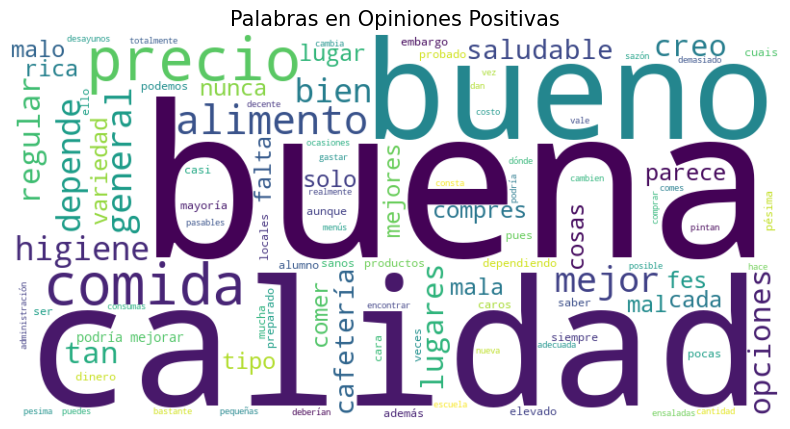

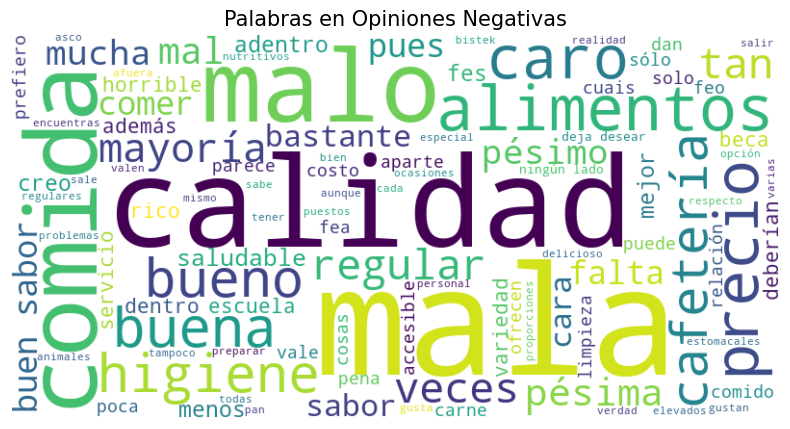

In [5]:
def graficar_wordcloud(texto, titulo):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='viridis',
                          max_words=100).generate(texto)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=15)
    plt.show()

# Unir todo el texto de opiniones positivas y negativas
texto_positivo = " ".join(df_clean[df_clean['sentimiento'] == 'Positivo']['opinion_limpia'])
texto_negativo = " ".join(df_clean[df_clean['sentimiento'] == 'Negativo']['opinion_limpia'])

graficar_wordcloud(texto_positivo, "Palabras en Opiniones Positivas")
graficar_wordcloud(texto_negativo, "Palabras en Opiniones Negativas")

## 4. Vectorización: Bag of Words (BOW)
Las máquinas no entienden texto, entienden números.
**Bag of Words** convierte cada opinión en un vector contando la frecuencia de cada palabra en el vocabulario total.
Imagina una tabla gigante donde las columnas son todas las palabras únicas del corpus y las filas son las opiniones.

In [6]:
# Inicializar el vectorizador
# max_features=1000: Nos quedamos con las 1000 palabras más frecuentes para no tener una matriz gigante
vectorizer = CountVectorizer(max_features=1000)

# Ajustar y transformar el texto limpio
X = vectorizer.fit_transform(df_clean['opinion_limpia'])

# Las etiquetas
y = df_clean['sentimiento']

print(f"Dimensiones de la matriz BOW: {X.shape}")
print(f"(Filas: Opiniones, Columnas: Palabras únicas)")

# Veamos algunas palabras del vocabulario
print(f"Ejemplos del vocabulario: {list(vectorizer.vocabulary_.keys())[:10]}")

Dimensiones de la matriz BOW: (221, 485)
(Filas: Opiniones, Columnas: Palabras únicas)
Ejemplos del vocabulario: ['lugares', 'vale', 'precio', 'comes', 'calidad', 'tan', 'mala', 'aunque', 'dan', 'costo']


## 5. Entrenamiento del Modelo
Usaremos una **Regresión Logística**. A pesar de su nombre, es un algoritmo de clasificación lineal muy efectivo para texto simple.
Dividiremos los datos en:
*   **Entrenamiento (80%)**: Para enseñar al modelo.
*   **Prueba (20%)**: Para evaluar qué tan bien aprendió.

In [7]:
# División Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y entrenar el modelo
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

print("¡Modelo entrenado exitosamente!")

¡Modelo entrenado exitosamente!


## 6. Evaluación y Pruebas
¿Qué tan bueno es nuestro "profesor artificial" calificando opiniones?

Exactitud (Accuracy) del modelo: 66.67%


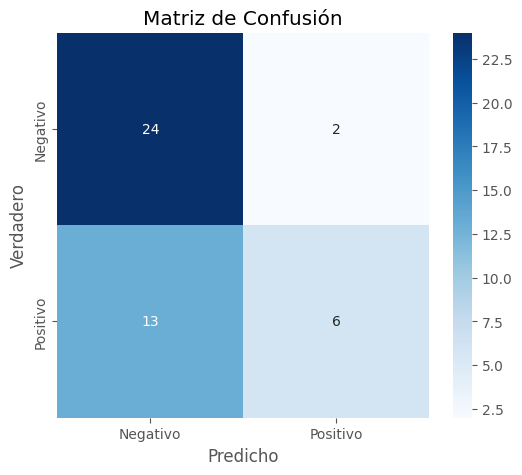

In [8]:
# Predecir en el conjunto de prueba
y_pred = modelo.predict(X_test)

# Calcular precisión
acc = accuracy_score(y_test, y_pred)
print(f"Exactitud (Accuracy) del modelo: {acc:.2%}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=modelo.classes_, yticklabels=modelo.classes_)
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

### ¡Pruébalo tú mismo!
Escribe una opinión y veamos qué dice el modelo.

In [9]:
def predecir_sentimiento(frase):
    # 1. Limpiar
    frase_limpia = limpiar_texto(frase)
    # 2. Vectorizar (usando el MISMO vectorizador entrenado)
    frase_vec = vectorizer.transform([frase_limpia])
    # 3. Predecir
    prediccion = modelo.predict(frase_vec)[0]
    proba = modelo.predict_proba(frase_vec).max()
    return f"Opinión: '{frase}' -> Sentimiento: {prediccion} (Confianza: {proba:.2%})"

# Ejemplos
print(predecir_sentimiento("La comida es deliciosa y muy barata"))
print(predecir_sentimiento("El servicio es lento y la comida está fría"))
print(predecir_sentimiento("No está mal, pero podría mejorar"))

Opinión: 'La comida es deliciosa y muy barata' -> Sentimiento: Negativo (Confianza: 73.33%)
Opinión: 'El servicio es lento y la comida está fría' -> Sentimiento: Negativo (Confianza: 81.44%)
Opinión: 'No está mal, pero podría mejorar' -> Sentimiento: Positivo (Confianza: 65.95%)
